# Wildfire Prediction


#### Tim Rolston #V00920780, Valeriya Savchenko #V00915341 

## Our Goal

In this notebook, we explore different data mining methods to clean, train, and test a dataset to create a model that can accurately predict the likehood of wildfires. 

Our initial idea was to have the model classify whether or not a fire will occur.
Using Linear Regression with a threshold of 0.4, we trained the model to classify a fire as "Fire!" and "No Fire".
We used a threshold of 0.4 because even though a fire may not start at a 0.4 likehood rating, the area is still highly prone to a fire and thus, it needs to be closely monitored. Anything below 0.4, can be classified as No Fire until features change and the model is run again on the changed features. After training the model on our data and getting the accuracy, we noted that the model does not quite fit our data well. We then tried an SGD classifier which also gave a very low accuracy score - 18%.

The last model we tried was the Decision Tree model. We decided to predict the frp, Fire Radiative Power, which detects how hot and powerful the fire is. As mentioned later in the notebook, this metric is more practical since it offers more information about the fire and allows for much better fire preparedness in regard to equipment and personnel needed to safely deal with it.

## Building a Wildfire Prediction

There are many ways to train a model to be able to predict wildfires in a given area. Some methods include using a rating system called "forest fire weather index" which is a mathematical equation that uses daily weather variables to calcuate the probability of a forest fire occuring. Another method to training an accurate wildfire prediction model uses multiple sources of satellite imaging collected from NASA's MODIS imaging system to gain insights into determining if an area has a high risk of a wildfire occuring. Originally we were interested in completing a model using MODIS data based off of 3 main sources; thermal anomalies, leaf area index, and surface temperature, similarily to how they do in this article https://www.sciencedirect.com/science/article/abs/pii/S0301479721024130?via%3Dihub. We later realized that the satellite imaging data is both hard to access remotely and fairly large to download to use locally, just one year of data was over 80Gigs of data.

## A Small Scale Model Using Big Data

We came to find a new dataset, access from NASA's Fire Information for Resource Management System (FIRMS) (https://firms.modaps.eosdis.nasa.gov/download/), that has much more manageable data that still shares insights on wildfires. This data is also collected from MODIS but is processed into numerical data that shows active fire products all around the world. From FIRMS we were able to download data from specific years which contained a file for each country. Since we only wanted to do a sample size of what can be done to manipulate wildfire data on a larger scale we chose to focus on using data from Canada, collected in 2021. This year in particular was chosen because we noticed there was a particular influx in wildfires that year compared to other years around it via http://nfdp.ccfm.org/en/data/fires.php. It is important to note this information as the premise of the model is biased in its own data, by only having data collected from a year high in wildfires, ideally we would also use data from other years low and medium in wildfires. This means that it is easy to overfit our data when comparing the model to real instances. In order to prevent this, we only compare the accuracy of this wildfire prediction model to wildfires that happened in 2021, otherwise we would be poorly representing the ability of this model. This is why we can consider our model to be a "small scale model" that can predict wildfires in the year 2021, that uses big data collected from this year.

### Get the dataset

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeRegressor

## About the data

Below shows the columns that the MODIS data contains. Latitude and longitude representing the location, brightness and bright_t31 which shows values for the colouration of the pixel on the image representing the temperature of the area using two different measuring devices. bright_t31 showing band 31 brightness temperature of fire pixel and brightness showing Band 21 brightness temperature of fire pixel. scan and track are values describing the resolution of the data. acq_date representing the date the image was collected, later this will be transformed into just months since we only have data from one year. acq_time shows the time in HHMM (hours,minutes) format. satellite represents the type of satellite that recorded the information (Terra or Aqua). The instrument feature shows the instrument that the data is collected with, in this case its all with MODIS. confidence is the percentage of confidence that there is a fire in the location and frp is the fire radiative power in Watts (MW). daynight show when the data was collected and type reffers to the inferred hotspot type (0 = presumed vegetation fire, 1 = active volcano, 2 = other static land source, 3 = offshore).

In this project we decided to explore training wildfire prediction models using confidence and frp as our target values as they seem to be the most useful in determining if there was a fire in the location.

In [11]:

wildfires = pd.read_csv("modis_2021_Canada.csv")

wildfires.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,54.8753,-117.4533,321.9,1.1,1.0,2021-01-01,522,Terra,MODIS,91,6.03,266.1,0.0,N,0
1,54.2008,-118.9019,313.9,1.2,1.1,2021-01-01,522,Terra,MODIS,88,6.03,267.7,23.4,N,0
2,55.3087,-111.7090,313.8,2.4,1.5,2021-01-02,1934,Terra,MODIS,0,6.03,265.3,67.6,D,0
3,54.4509,-107.1336,305.0,4.0,1.9,2021-01-02,1934,Terra,MODIS,34,6.03,265.1,94.0,D,0
4,54.4552,-107.1247,322.5,4.0,1.9,2021-01-02,1934,Terra,MODIS,0,6.03,265.8,197.2,D,0


In [12]:
wildfires.isnull().sum()

latitude      0
longitude     0
brightness    0
scan          0
track         0
acq_date      0
acq_time      0
satellite     0
instrument    0
confidence    0
version       0
bright_t31    0
frp           0
daynight      0
type          0
dtype: int64

In [13]:
wildfires.describe()

,latitude,longitude,brightness,scan,track,acq_time,confidence,version,bright_t31,frp,type
count,97100.000000,97100.000000,97100.000000,97100.000000,97100.000000,97100.000000,97100.000000,97100.00,97100.000000,97100.000000,97100.000000
mean,53.557203,-109.326503,333.503459,1.670557,1.229398,1404.042894,67.413913,6.03,294.314910,108.334157,0.004985
std,3.968219,12.862361,28.765267,0.866015,0.260027,668.912790,30.852951,0.00,9.833665,281.002078,0.099721
min,42.047000,-140.984700,300.000000,1.000000,1.000000,141.000000,0.000000,6.03,264.400000,0.000000,0.000000
25%,50.855600,-120.871800,314.000000,1.100000,1.000000,607.000000,49.000000,6.03,289.000000,17.700000,0.000000
50%,52.260300,-105.455850,326.000000,1.300000,1.100000,1812.000000,75.000000,6.03,294.500000,37.800000,0.000000
75%,55.465825,-96.462950,344.100000,1.900000,1.400000,1943.000000,95.000000,6.03,300.000000,91.400000,0.000000
max,68.400800,-54.819900,507.900000,4.800000,2.000000,2311.000000,100.000000,6.03,400.100000,12808.400000,2.000000


### Remove 'instrument' and 'version' from the dataset as they arent useful

In [14]:
wildfires.drop('instrument', axis=1, inplace=True)
wildfires.drop('version', axis=1, inplace=True)
wildfires.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,confidence,bright_t31,frp,daynight,type
0,54.8753,-117.4533,321.9,1.1,1.0,2021-01-01,522,Terra,91,266.1,0.0,N,0
1,54.2008,-118.9019,313.9,1.2,1.1,2021-01-01,522,Terra,88,267.7,23.4,N,0
2,55.3087,-111.7090,313.8,2.4,1.5,2021-01-02,1934,Terra,0,265.3,67.6,D,0
3,54.4509,-107.1336,305.0,4.0,1.9,2021-01-02,1934,Terra,34,265.1,94.0,D,0
4,54.4552,-107.1247,322.5,4.0,1.9,2021-01-02,1934,Terra,0,265.8,197.2,D,0


### Change 'satellite' and 'daynight' values to integers

In [15]:
wildfires['satellite'] = wildfires['satellite'].astype('category').cat.codes
wildfires['daynight'] = wildfires['daynight'].astype('category').cat.codes
wildfires['month'] = wildfires['acq_date'].apply(lambda x:int(x.split('-')[1]))
wildfires.drop('acq_date', axis=1, inplace=True)
wildfires.head()

,latitude,longitude,brightness,scan,track,acq_time,satellite,confidence,bright_t31,frp,daynight,type,month
0,54.8753,-117.4533,321.9,1.1,1.0,522,1,91,266.1,0.0,1,0,1
1,54.2008,-118.9019,313.9,1.2,1.1,522,1,88,267.7,23.4,1,0,1
2,55.3087,-111.7090,313.8,2.4,1.5,1934,1,0,265.3,67.6,0,0,1
3,54.4509,-107.1336,305.0,4.0,1.9,1934,1,34,265.1,94.0,0,0,1
4,54.4552,-107.1247,322.5,4.0,1.9,1934,1,0,265.8,197.2,0,0,1


In [16]:
wildfires.corr()

,latitude,longitude,brightness,scan,track,acq_time,satellite,confidence,bright_t31,frp,daynight,type,month
latitude,1.000000,-0.307643,0.032445,0.035222,0.038626,0.082573,0.036753,-0.052645,-0.018700,0.019916,-0.087393,-0.108377,0.073000
longitude,-0.307643,1.000000,0.006891,-0.027327,-0.028239,-0.048188,-0.033966,-0.150344,0.102708,-0.026073,-0.067138,0.093504,-0.135966
brightness,0.032445,0.006891,1.000000,-0.066879,-0.065368,0.228201,-0.088433,0.397022,0.600865,0.653885,-0.235988,-0.042871,-0.080730
scan,0.035222,-0.027327,-0.066879,1.000000,0.983855,0.077492,-0.019243,-0.094234,-0.111862,0.231463,-0.085997,-0.018168,-0.045187
track,0.038626,-0.028239,-0.065368,0.983855,1.000000,0.083708,-0.017634,-0.096394,-0.110528,0.228622,-0.092989,-0.018758,-0.045479
acq_time,0.082573,-0.048188,0.228201,0.077492,0.083708,1.000000,-0.459672,-0.153145,0.339904,0.104029,-0.955178,-0.006437,0.010789
satellite,0.036753,-0.033966,-0.088433,-0.019243,-0.017634,-0.459672,1.000000,0.051623,-0.128841,-0.046525,0.283910,0.004633,-0.009546
confidence,-0.052645,-0.150344,0.397022,-0.094234,-0.096394,-0.153145,0.051623,1.000000,0.147495,0.171580,0.172209,-0.040122,-0.000388
bright_t31,-0.018700,0.102708,0.600865,-0.111862,-0.110528,0.339904,-0.128841,0.147495,1.000000,0.340096,-0.359160,-0.015062,-0.223897
frp,0.019916,-0.026073,0.653885,0.231463,0.228622,0.104029,-0.046525,0.171580,0.340096,1.000000,-0.105253,-0.016887,-0.049749


#### Above, it is clear that the feature 'scan' also has little correlation with either of our target features 'frp' or 'confidence' so we will also remove it


#### Now we want to visualize the correlation

<Axes: >

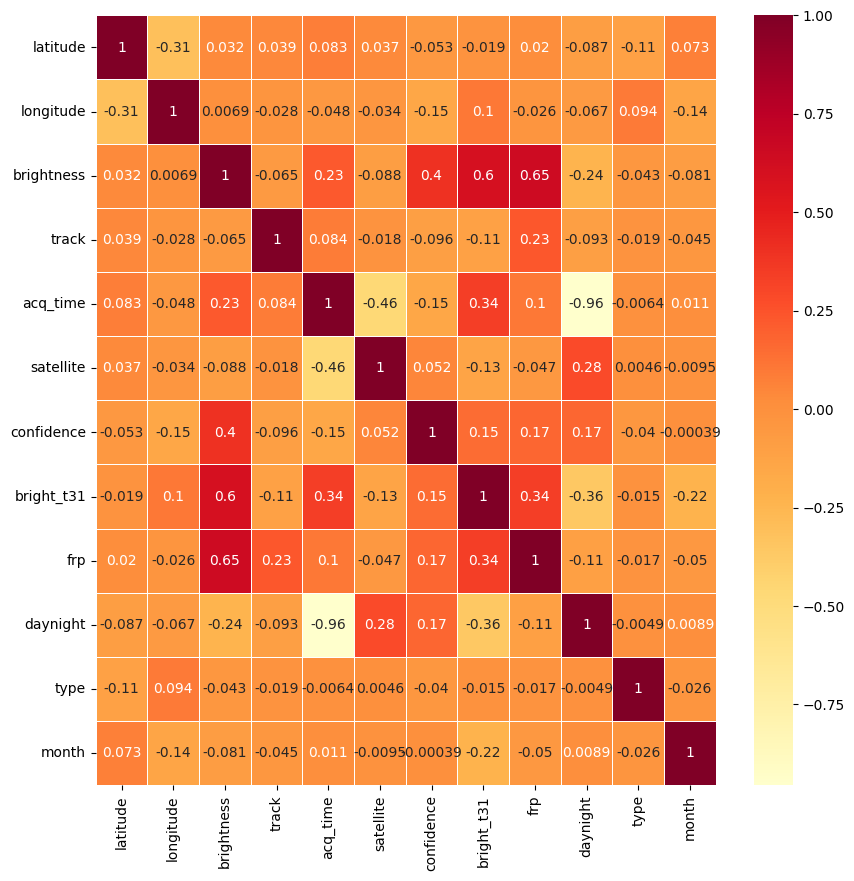

In [17]:
wildfire_clean_set = wildfires.drop(['scan'], axis = 1)
plt.figure(figsize=(10, 10))
sns.heatmap(wildfire_clean_set.corr(),annot=True,cmap='YlOrRd',linewidths=.5)

### We need to scale the dataset to use the same scale for all features! (CURRENTLY NOT USED)

In [18]:
#from sklearn.preprocessing import MinMaxScaler

#def scale_dataset(dataset):
#    scaler = MinMaxScaler(feature_range=(0, 1))  # Scale to 0-1
#    scaled_dataset = scaler.fit_transform(dataset)
#    return scaled_dataset

#scaled_dataset = scale_dataset(wildfire_clean_set)

#for i, row in enumerate(scaled_dataset[:10]):
#   print(row)

### Prepare the dataset
#### We need to split the dataset into the training and the target set
here we will be using 'confidence' as our target. For cofidence we can use classification since its values are between 0 and 100 (representing a percentage). To start off we will try a Stoachastic Gradient Decent to fit the classifier.

In [19]:
X_wildfires = wildfire_clean_set.drop(['confidence'], axis = 1)
y_wildfires = wildfires['confidence']


X_train, X_test, y_train, y_test = train_test_split(X_wildfires, y_wildfires, test_size=0.2, random_state=42)

### Do stuff
#### Now that the data has the same scale and is split into the different sets, we can start training the model using Logistic Regression (THIS METHOD IS NOT CURRENTLY USED)

In [20]:
#from sklearn.linear_model import LogisticRegression

#logreg = LogisticRegression(solver='lbfgs', max_iter=10000)

#logreg.fit(X_train, y_train)

#y_pred_prob = logreg.predict_proba(X_test)[:, 1]

#y_pred = ['Fire!' if prob >= 0.4 else 'No Fire' for prob in y_pred_prob]

#from sklearn.metrics import accuracy_score

#accuracy = accuracy_score(y_testy, y_pred)
#print("Accuracy:", accuracy)

### SGD Section

Below is the steps we took to creating a SGD classifier to train the wildfire model on predicting the confidence of a fire happening given its features. The training is fairly inefficient for how small the dataset actually is as the total time to run takes approximately **22 minutes**. The accuracy was also quite low at around **18%**. It is clear that we needed a more complex model that can train with more efficiency and provide better accuracy. 

To achieve this we thought of two main things we could change about our training model. First we decided that it would be wise to use a decision tree to significantly speed up the process of training. We also re-evaluated some of the correlations and decided to switch our target to frp instead of confidence, to try and raise our accuracy. However, using frp as our target meant that we would have to use regression instead of classification as its values are continuous.

In [21]:
#Create SGD classifier
#sgd_clf = SGDClassifier(random_state=42)
#sgd_clf.fit(X_wildfires, y_wildfires)



In [22]:
# Evaluate the accuracy of the classifier

#accuracy = cross_val_score(sgd_clf, X_wildfires, y_wildfires, cv=10, scoring="accuracy")
#print("Accuracy:", accuracy)


In [23]:
#np.mean(accuracy)

### Decision Tree Regression 



In [24]:
X_wildfires_reg = wildfire_clean_set.drop(['frp'], axis = 1)
y_wildfires_reg = wildfires['frp']


X_train, X_test, y_train, y_test = train_test_split(X_wildfires_reg, y_wildfires_reg, test_size=0.2, random_state=42)

In [25]:
# Create the decision tree classifier
reg = DecisionTreeRegressor(random_state=23)

# Train the classifier on the training data
reg.fit(X_train, y_train)

DecisionTreeRegressor(random_state=23)

In [27]:
reg.score(X_test,y_test)

0.9027035648576787

Here we can see that both the run time and accuracy are much better when using a DTR with frp as the target. Rather than predicting the likelihood of a fire, which is not as relevant because the process is very likely to have fires, it makes more sense for us to predict the intensity of the fire - the frp. This prediction is more useful to firefighters, park rangers, and anyone else invested in the fire situation. Those parties can extract this information from our model and be more prepared for the situation. There is a difference in knowing whether or not there is a fire and knowing how large the fire is. With larger fires, more equipment and personnel are needed. Additionally, if the fire is in a highly populated area, civilians need to be prepared to evacuate.
For all of these reasons, we commented the other models out and kept our Decision Tree model. It is the most realistic model and it provides the most accuracy.